In [204]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import scipy as sp
import sklearn.metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA
from itertools import combinations
from sklearn.model_selection import cross_val_score
pd.set_option('display.max.columns', 500)
pd.set_option('display.max.rows', 500)
plt.style.use('seaborn-whitegrid')
plt.rc('font', family='Malgun Gothic')
os.chdir('C:\\Users\\twa02\\Desktop\\Machine Learning\\퓨쳐스리그')

# 개인투수 전처리

In [205]:
#데이터 불러오기
YEAR_LIST = [2016, 2017, 2018, 2019, 2020]
for i in YEAR_LIST:
    s1 = "pitcher_%d = pd.read_csv(r'C:\\Users\\twa02\\Desktop\\Machine Learning\\퓨쳐스리그\\데이터\\시즌별 csv 구분\\개인투수\\2020빅콘테스트_스포츠투아이_제공데이터_개인투수_%d.csv', encoding='cp949')"%(i, i)
    exec(s1)
    
for i in YEAR_LIST:
    s2 = "player_%d = pd.read_csv(r'C:\\Users\\twa02\\Desktop\\Machine Learning\\퓨쳐스리그\\데이터\\시즌별 csv 구분\\선수\\2020빅콘테스트_스포츠투아이_제공데이터_선수_%d.csv', encoding='cp949')"%(i, i)
    exec(s2)

In [206]:
#불필요한 피쳐 제거
YEAR_LIST = [2016, 2017, 2018, 2019, 2020]
for i in YEAR_LIST:
    s1 = "data_%d = pitcher_%d.drop(['VS_T_ID', 'HEADER_NO', 'TB_SC', 'CG_CK', 'WLS', 'HOLD', 'GD', 'WP', 'BK'],axis = 1)"%(i, i)
    exec(s1)

In [207]:
#INN2 0제거
for i in YEAR_LIST:
    s1 = "drop_in_%d = data_%d.loc[data_%d['INN2'] == 0].index"%(i, i, i)
    exec(s1)
    
for i in YEAR_LIST:
    s2 = "data_%d = data_%d.drop(drop_in_%d).rename(columns = {'P_ID' : 'PCODE'})"%(i, i, i)
    exec(s2)

In [208]:
#투수 템프릿
for i in YEAR_LIST:
    s1 = "pit_%d = data_%d['PCODE'].drop_duplicates()"%(i, i)
    exec(s1)
    
#해당년도 선수, 이름, 나이 정리
for i in YEAR_LIST:
    s2 = "player_temp_%d = pd.concat([player_%d['PCODE'], player_%d['NAME'], player_%d['T_ID'], player_%d['AGE_VA']], axis = 1)"%(i, i, i, i, i)
    exec(s2)

#병합
for i in YEAR_LIST:
    s3 = "pit_%d = pd.merge(pit_%d, player_temp_%d, on = 'PCODE', how = 'left')"%(i, i, i)
    exec(s3)
    
#이닝 구하기
for i in YEAR_LIST:
    s4 = "data_%d['INN'] = data_%d['INN2']*(1/3)"%(i, i)
    exec(s4)

In [209]:
#날짜변경
data_list = [data_2016, data_2017, data_2018, data_2019, data_2020]
for i in data_list:
    i['GDAY_DS'] = pd.to_datetime(i['GDAY_DS'].astype(str), format = '%Y-%m-%d')

In [210]:
#경기수에 맞게 추출(현재 120경기 기준)
YEAR_LIST_2 = [2016, 2017, 2018, 2019]
TEAM_LIST = ['LG', 'SS', 'HH', 'LT', 'NC', 'HT', 'WO', 'SK', 'KT', 'OB']
for i in YEAR_LIST_2:
    for j in TEAM_LIST:
        #120 숫자를 원하는 경기수만큼 변경하면 추출가능
        s1 = "%s_%d = data_%d.loc[data_%d['T_ID'] == j]['G_ID'].drop_duplicates().reset_index(drop = True)[:120]"%(j, i, i, i)
        exec(s1)
        
for i in YEAR_LIST_2:
    for j in TEAM_LIST:
        #최종시즌 ERA 담을 데이터프레임
        s1 = "%s_%d_ERA = data_%d.loc[data_%d['T_ID'] == j]['G_ID'].drop_duplicates().reset_index(drop = True)[:144]"%(j, i, i, i)
        exec(s1)
        
for i in YEAR_LIST_2:
    for j in TEAM_LIST:
        s2 = "train_%s_%d = pd.merge(%s_%d, data_%d.loc[data_%d['T_ID'] == j], on = 'G_ID', how = 'left')"%(j, i, j, i, i, i)
        exec(s2)
        
for i in YEAR_LIST_2:
    for j in TEAM_LIST:
        s2 = "train_%s_%d_ERA = pd.merge(%s_%d_ERA, data_%d.loc[data_%d['T_ID'] == j], on = 'G_ID', how = 'left')"%(j, i, j, i, i, i)
        exec(s2)

In [211]:
#경기추출하고 데이터 병합
team_2016 = pd.concat([train_LG_2016, train_SS_2016, train_HH_2016, train_LT_2016, train_NC_2016, train_HT_2016, train_WO_2016,
          train_SK_2016, train_KT_2016, train_OB_2016], axis = 0).reset_index(drop=True)

team_2017 = pd.concat([train_LG_2017, train_SS_2017, train_HH_2017, train_LT_2017, train_NC_2017, train_HT_2017, train_WO_2017,
          train_SK_2017, train_KT_2017, train_OB_2017], axis = 0).reset_index(drop=True)

team_2018 = pd.concat([train_LG_2018, train_SS_2018, train_HH_2018, train_LT_2018, train_NC_2018, train_HT_2018, train_WO_2018,
          train_SK_2018, train_KT_2018, train_OB_2018], axis = 0).reset_index(drop=True)

team_2019 = pd.concat([train_LG_2019, train_SS_2019, train_HH_2019, train_LT_2019, train_NC_2019, train_HT_2019, train_WO_2019,
          train_SK_2019, train_KT_2019, train_OB_2019], axis = 0).reset_index(drop=True)

#최종ERA담을 데이터
team_2016_ERA = pd.concat([train_LG_2016_ERA, train_SS_2016_ERA, train_HH_2016_ERA, train_LT_2016_ERA, train_NC_2016_ERA, train_HT_2016_ERA, train_WO_2016_ERA,
          train_SK_2016_ERA, train_KT_2016_ERA, train_OB_2016_ERA], axis = 0).reset_index(drop=True)

team_2017_ERA = pd.concat([train_LG_2017_ERA, train_SS_2017_ERA, train_HH_2017_ERA, train_LT_2017_ERA, train_NC_2017_ERA, train_HT_2017_ERA, train_WO_2017_ERA,
          train_SK_2017_ERA, train_KT_2017_ERA, train_OB_2017_ERA], axis = 0).reset_index(drop=True)

team_2018_ERA = pd.concat([train_LG_2018_ERA, train_SS_2018_ERA, train_HH_2018_ERA, train_LT_2018_ERA, train_NC_2018_ERA, train_HT_2018_ERA, train_WO_2018_ERA,
          train_SK_2018_ERA, train_KT_2018_ERA, train_OB_2018_ERA], axis = 0).reset_index(drop=True)

team_2019_ERA = pd.concat([train_LG_2019_ERA, train_SS_2019_ERA, train_HH_2019_ERA, train_LT_2019_ERA, train_NC_2019_ERA, train_HT_2019_ERA, train_WO_2019_ERA,
          train_SK_2019_ERA, train_KT_2019_ERA, train_OB_2019_ERA], axis = 0).reset_index(drop=True)

In [212]:
#ERA를 담을 리스트
for i in YEAR_LIST:
    s1 = "ERA_%d = []"%(i)
    exec(s1)
#ERA 담기
for i in pit_2016['PCODE']:
    SCORE_2016 = (team_2016.loc[team_2016['PCODE'] == i]['ER'].sum() * 27)/team_2016.loc[team_2016['PCODE'] == i]['INN2'].sum()
    ERA_2016.append(SCORE_2016)
    
for i in pit_2017['PCODE']:
    SCORE_2017 = (team_2017.loc[team_2017['PCODE'] == i]['ER'].sum() * 27)/team_2017.loc[team_2017['PCODE'] == i]['INN2'].sum()
    ERA_2017.append(SCORE_2017)
    
for i in pit_2018['PCODE']:
    SCORE_2018 = (team_2018.loc[team_2018['PCODE'] == i]['ER'].sum() * 27)/team_2018.loc[team_2018['PCODE'] == i]['INN2'].sum()
    ERA_2018.append(SCORE_2018)
    
for i in pit_2019['PCODE']:
    SCORE_2019 = (team_2019.loc[team_2019['PCODE'] == i]['ER'].sum() * 27)/team_2019.loc[team_2019['PCODE'] == i]['INN2'].sum()
    ERA_2019.append(SCORE_2019)
    
#최종ERA를 담을 리스트
for i in YEAR_LIST:
    s1 = "FINAL_ERA_%d = []"%(i)
    exec(s1)
#ERA 담기
for i in pit_2016['PCODE']:
    SCORE_2016 = (team_2016_ERA.loc[team_2016_ERA['PCODE'] == i]['ER'].sum() * 27)/team_2016_ERA.loc[team_2016_ERA['PCODE'] == i]['INN2'].sum()
    FINAL_ERA_2016.append(SCORE_2016)
    
for i in pit_2017['PCODE']:
    SCORE_2017 = (team_2017_ERA.loc[team_2017_ERA['PCODE'] == i]['ER'].sum() * 27)/team_2017_ERA.loc[team_2017_ERA['PCODE'] == i]['INN2'].sum()
    FINAL_ERA_2017.append(SCORE_2017)
    
for i in pit_2018['PCODE']:
    SCORE_2018 = (team_2018_ERA.loc[team_2018_ERA['PCODE'] == i]['ER'].sum() * 27)/team_2018_ERA.loc[team_2018_ERA['PCODE'] == i]['INN2'].sum()
    FINAL_ERA_2018.append(SCORE_2018)
    
for i in pit_2019['PCODE']:
    SCORE_2019 = (team_2019_ERA.loc[team_2019_ERA['PCODE'] == i]['ER'].sum() * 27)/team_2019_ERA.loc[team_2019_ERA['PCODE'] == i]['INN2'].sum()
    FINAL_ERA_2019.append(SCORE_2019)

In [213]:
#WHIP를 담을 리스트
for i in YEAR_LIST:
    s1 = "WHIP_%d = []"%(i)
    exec(s1)
#WHIP 담기   
for i in pit_2016['PCODE']:
    SCORE_2016 = ((team_2016.loc[team_2016['PCODE'] == i]['HIT'].sum() + team_2016.loc[team_2016['PCODE'] == i]['BB'].sum())*3)/team_2016.loc[team_2016['PCODE'] == i]['INN2'].sum()
    WHIP_2016.append(SCORE_2016)
    
for i in pit_2017['PCODE']:
    SCORE_2017 = ((team_2017.loc[team_2017['PCODE'] == i]['HIT'].sum() + team_2017.loc[team_2017['PCODE'] == i]['BB'].sum())*3)/team_2017.loc[team_2017['PCODE'] == i]['INN2'].sum()
    WHIP_2017.append(SCORE_2017)
    
for i in pit_2018['PCODE']:
    SCORE_2018 = ((team_2018.loc[team_2018['PCODE'] == i]['HIT'].sum() + team_2018.loc[team_2018['PCODE'] == i]['BB'].sum())*3)/team_2018.loc[team_2018['PCODE'] == i]['INN2'].sum()
    WHIP_2018.append(SCORE_2018)
    
for i in pit_2019['PCODE']:
    SCORE_2019 = ((team_2019.loc[team_2019['PCODE'] == i]['HIT'].sum() + team_2019.loc[team_2019['PCODE'] == i]['BB'].sum())*3)/team_2019.loc[team_2019['PCODE'] == i]['INN2'].sum()
    WHIP_2019.append(SCORE_2019)

In [214]:
#스텟 리스트 생성
STAT_LIST = ['HIT', 'H2', 'H3', 'HR', 'BB', 'IB', 'HP', 'KK', 'ERR', 'INN2', 'INN']
for i in YEAR_LIST:
    for j in STAT_LIST:
        s1 = "%s_%d = []"%(j, i)
        exec(s1)

In [215]:
for i in pit_2016['PCODE']:
    SCORE_1 = team_2016.loc[team_2016['PCODE'] == i]['HIT'].sum()
    SCORE_2 = team_2016.loc[team_2016['PCODE'] == i]['H2'].sum()
    SCORE_3 = team_2016.loc[team_2016['PCODE'] == i]['H3'].sum()
    SCORE_4 = team_2016.loc[team_2016['PCODE'] == i]['HR'].sum()
    SCORE_5 = team_2016.loc[team_2016['PCODE'] == i]['BB'].sum()
    SCORE_6 = team_2016.loc[team_2016['PCODE'] == i]['IB'].sum()
    SCORE_7 = team_2016.loc[team_2016['PCODE'] == i]['HP'].sum()
    SCORE_8 = team_2016.loc[team_2016['PCODE'] == i]['KK'].sum()
    SCORE_9 = team_2016.loc[team_2016['PCODE'] == i]['ERR'].sum()
    SCORE_10 = team_2016.loc[team_2016['PCODE'] == i]['INN2'].sum()
    SCORE_11 = team_2016.loc[team_2016['PCODE'] == i]['INN'].sum()    
    
    HIT_2016.append(SCORE_1)
    H2_2016.append(SCORE_2)
    H3_2016.append(SCORE_3)
    HR_2016.append(SCORE_4)
    BB_2016.append(SCORE_5)
    IB_2016.append(SCORE_6)
    HP_2016.append(SCORE_7)
    KK_2016.append(SCORE_8)
    ERR_2016.append(SCORE_9)
    INN2_2016.append(SCORE_10)
    INN_2016.append(SCORE_11)

In [216]:
for i in pit_2017['PCODE']:
    SCORE_1 = team_2017.loc[team_2017['PCODE'] == i]['HIT'].sum()
    SCORE_2 = team_2017.loc[team_2017['PCODE'] == i]['H2'].sum()
    SCORE_3 = team_2017.loc[team_2017['PCODE'] == i]['H3'].sum()
    SCORE_4 = team_2017.loc[team_2017['PCODE'] == i]['HR'].sum()
    SCORE_5 = team_2017.loc[team_2017['PCODE'] == i]['BB'].sum()
    SCORE_6 = team_2017.loc[team_2017['PCODE'] == i]['IB'].sum()
    SCORE_7 = team_2017.loc[team_2017['PCODE'] == i]['HP'].sum()
    SCORE_8 = team_2017.loc[team_2017['PCODE'] == i]['KK'].sum()
    SCORE_9 = team_2017.loc[team_2017['PCODE'] == i]['ERR'].sum()
    SCORE_10 = team_2017.loc[team_2017['PCODE'] == i]['INN2'].sum()
    SCORE_11 = team_2017.loc[team_2017['PCODE'] == i]['INN'].sum()    
    
    HIT_2017.append(SCORE_1)
    H2_2017.append(SCORE_2)
    H3_2017.append(SCORE_3)
    HR_2017.append(SCORE_4)
    BB_2017.append(SCORE_5)
    IB_2017.append(SCORE_6)
    HP_2017.append(SCORE_7)
    KK_2017.append(SCORE_8)
    ERR_2017.append(SCORE_9)
    INN2_2017.append(SCORE_10)
    INN_2017.append(SCORE_11)

In [217]:
for i in pit_2018['PCODE']:
    SCORE_1 = team_2018.loc[team_2018['PCODE'] == i]['HIT'].sum()
    SCORE_2 = team_2018.loc[team_2018['PCODE'] == i]['H2'].sum()
    SCORE_3 = team_2018.loc[team_2018['PCODE'] == i]['H3'].sum()
    SCORE_4 = team_2018.loc[team_2018['PCODE'] == i]['HR'].sum()
    SCORE_5 = team_2018.loc[team_2018['PCODE'] == i]['BB'].sum()
    SCORE_6 = team_2018.loc[team_2018['PCODE'] == i]['IB'].sum()
    SCORE_7 = team_2018.loc[team_2018['PCODE'] == i]['HP'].sum()
    SCORE_8 = team_2018.loc[team_2018['PCODE'] == i]['KK'].sum()
    SCORE_9 = team_2018.loc[team_2018['PCODE'] == i]['ERR'].sum()
    SCORE_10 = team_2018.loc[team_2018['PCODE'] == i]['INN2'].sum()
    SCORE_11 = team_2018.loc[team_2018['PCODE'] == i]['INN'].sum()    
    
    HIT_2018.append(SCORE_1)
    H2_2018.append(SCORE_2)
    H3_2018.append(SCORE_3)
    HR_2018.append(SCORE_4)
    BB_2018.append(SCORE_5)
    IB_2018.append(SCORE_6)
    HP_2018.append(SCORE_7)
    KK_2018.append(SCORE_8)
    ERR_2018.append(SCORE_9)
    INN2_2018.append(SCORE_10)
    INN_2018.append(SCORE_11)

In [218]:
for i in pit_2019['PCODE']:
    SCORE_1 = team_2019.loc[team_2019['PCODE'] == i]['HIT'].sum()
    SCORE_2 = team_2019.loc[team_2019['PCODE'] == i]['H2'].sum()
    SCORE_3 = team_2019.loc[team_2019['PCODE'] == i]['H3'].sum()
    SCORE_4 = team_2019.loc[team_2019['PCODE'] == i]['HR'].sum()
    SCORE_5 = team_2019.loc[team_2019['PCODE'] == i]['BB'].sum()
    SCORE_6 = team_2019.loc[team_2019['PCODE'] == i]['IB'].sum()
    SCORE_7 = team_2019.loc[team_2019['PCODE'] == i]['HP'].sum()
    SCORE_8 = team_2019.loc[team_2019['PCODE'] == i]['KK'].sum()
    SCORE_9 = team_2019.loc[team_2019['PCODE'] == i]['ERR'].sum()
    SCORE_10 = team_2019.loc[team_2019['PCODE'] == i]['INN2'].sum()
    SCORE_11 = team_2019.loc[team_2019['PCODE'] == i]['INN'].sum()    
    
    HIT_2019.append(SCORE_1)
    H2_2019.append(SCORE_2)
    H3_2019.append(SCORE_3)
    HR_2019.append(SCORE_4)
    BB_2019.append(SCORE_5)
    IB_2019.append(SCORE_6)
    HP_2019.append(SCORE_7)
    KK_2019.append(SCORE_8)
    ERR_2019.append(SCORE_9)
    INN2_2019.append(SCORE_10)
    INN_2019.append(SCORE_11)

In [219]:
CHANGE_LIST = ['pit', 'ERA', 'WHIP', 'HIT', 'H2', 'H3', 'HR', 'BB', 'IB', 'HP', 'KK', 'ERR', 'INN2', 'INN', 'FINAL_ERA']
for i in YEAR_LIST_2:
    for j in CHANGE_LIST:
        s1 = "%s_%d = pd.DataFrame(%s_%d).reset_index(drop=True)"%(j,i,j,i)
        exec(s1)
#이름변경        
NAME = ['ERA', 'WHIP', 'HIT', 'H2', 'H3', 'HR', 'BB', 'IB', 'HP', 'KK', 'ERR', 'INN2', 'INN', 'FINAL_ERA']
for i in NAME:
    for j in YEAR_LIST_2:
        s2 = "%s_%d = %s_%d.rename(columns = {0 : '%s'})"%(i,j,i,j,i)
        exec(s2)

In [220]:
#120경기 기준 득점권 WHIP, 2점차이하 WHIP, 345번 WHIP 평균추출
WHIP_LIST = ['P_WHIP_RT', 'P2_WHIP_RT', 'CB_WHIP_RT']

for i in WHIP_LIST:
    for j in YEAR_LIST_2:
        s1 = "%s_%d = pd.DataFrame(team_%d.groupby(['PCODE'])['%s'].mean()).reset_index()"%(i,j,j,i)
        exec(s1)

In [221]:
#데이터 병합
train_2016 = pd.concat([pit_2016, ERA_2016, HIT_2016, H2_2016, H3_2016, HR_2016, BB_2016, WHIP_2016,
                        IB_2016, HP_2016, KK_2016, ERR_2016, INN2_2016, INN_2016, FINAL_ERA_2016], axis = 1).dropna(axis = 0)

train_2017 = pd.concat([pit_2017, ERA_2017, HIT_2017, H2_2017, H3_2017, HR_2017, BB_2017, WHIP_2017,
                        IB_2017, HP_2017, KK_2017, ERR_2017, INN2_2017, INN_2017, FINAL_ERA_2017], axis = 1).dropna(axis = 0)

train_2018 = pd.concat([pit_2018, ERA_2018, HIT_2018, H2_2018, H3_2018, HR_2018, BB_2018, WHIP_2018,
                        IB_2018, HP_2018, KK_2018, ERR_2018, INN2_2018, INN_2018, FINAL_ERA_2018], axis = 1).dropna(axis = 0)

train_2019 = pd.concat([pit_2019, ERA_2019, HIT_2019, H2_2019, H3_2019, HR_2019, BB_2019, WHIP_2019,
                        IB_2019, HP_2019, KK_2019, ERR_2019, INN2_2019, INN_2019, FINAL_ERA_2019], axis = 1).dropna(axis = 0)

In [222]:
#위에서 만든 WHIP지표 병합
WHIP_2016 = pd.merge(P_WHIP_RT_2016, P2_WHIP_RT_2016, on = 'PCODE', how = 'left')
WHIP_2016 = pd.merge(WHIP_2016, CB_WHIP_RT_2016, on = 'PCODE', how = 'left')

WHIP_2017 = pd.merge(P_WHIP_RT_2017, P2_WHIP_RT_2017, on = 'PCODE', how = 'left')
WHIP_2017 = pd.merge(WHIP_2017, CB_WHIP_RT_2017, on = 'PCODE', how = 'left')

WHIP_2018 = pd.merge(P_WHIP_RT_2018, P2_WHIP_RT_2018, on = 'PCODE', how = 'left')
WHIP_2018 = pd.merge(WHIP_2018, CB_WHIP_RT_2018, on = 'PCODE', how = 'left')

WHIP_2019 = pd.merge(P_WHIP_RT_2019, P2_WHIP_RT_2019, on = 'PCODE', how = 'left')
WHIP_2019 = pd.merge(WHIP_2019, CB_WHIP_RT_2019, on = 'PCODE', how = 'left')

In [223]:
#기존 연도별 데이터와 WHIP데이터 병합
for i in YEAR_LIST_2:
    s1 = "train_%d = pd.merge(train_%d, WHIP_%d, on = 'PCODE', how = 'left')"%(i, i, i)
    exec(s1)

In [224]:
#연도 변수 생성
for i in YEAR_LIST_2:
    s1 = "train_%d['YEAR'] = %d"%(i, i)
    exec(s1)

In [225]:
#FIP구하기
train_2016['FIP'] = ((-2*train_2016['KK'] + 3*(train_2016['BB'] + train_2016['IB'] + train_2016['HP']) + 13*(train_2016['HR']))/train_2016['INN']) + 3.792
train_2017['FIP'] = ((-2*train_2017['KK'] + 3*(train_2017['BB'] + train_2017['IB'] + train_2017['HP']) + 13*(train_2017['HR']))/train_2017['INN']) + 3.735
train_2018['FIP'] = ((-2*train_2018['KK'] + 3*(train_2018['BB'] + train_2018['IB'] + train_2018['HP']) + 13*(train_2018['HR']))/train_2018['INN']) + 3.833
train_2019['FIP'] = ((-2*train_2019['KK'] + 3*(train_2019['BB'] + train_2019['IB'] + train_2019['HP']) + 13*(train_2019['HR']))/train_2019['INN']) + 3.403
#train_2020['FIP'] = ((-2*train_2020['KK'] + 3*(train_2020['BB'] + train_2020['IB'] + train_2020['HP']) + 13*(train_2020['HR']))/train_2020['INN']) + 3.609

In [226]:
#1루타 피쳐 생성
train_2016['H1'] = train_2016['HIT'] - train_2016['H2'] - train_2016['H3'] - train_2016['HR']
train_2017['H1'] = train_2017['HIT'] - train_2017['H2'] - train_2017['H3'] - train_2017['HR']
train_2018['H1'] = train_2018['HIT'] - train_2018['H2'] - train_2018['H3'] - train_2018['HR']
train_2019['H1'] = train_2019['HIT'] - train_2019['H2'] - train_2019['H3'] - train_2019['HR']

In [227]:
#C구하기
#C_2016 = train_2016['ERA'].mean() - (((13*train_2016['HR'].sum())+(3*(train_2016['BB'].sum() + train_2016['IB'].sum() + train_2016['HP'].sum())) - (2*train_2016['KK'].sum()))/train_2016['INN'].sum())

#C_2017 = train_2017['ERA'].mean() - (((13*train_2017['HR'].sum())+(3*(train_2017['BB'].sum() + train_2017['IB'].sum() + train_2017['HP'].sum())) - (2*train_2017['KK'].sum()))/train_2017['INN'].sum())

#C_2018 = train_2018['ERA'].mean() - (((13*train_2018['HR'].sum())+(3*(train_2018['BB'].sum() + train_2018['IB'].sum() + train_2018['HP'].sum())) - (2*train_2018['KK'].sum()))/train_2018['INN'].sum())

#C_2019 = train_2019['ERA'].mean() - (((13*train_2019['HR'].sum())+(3*(train_2019['BB'].sum() + train_2019['IB'].sum() + train_2019['HP'].sum())) - (2*train_2019['KK'].sum()))/train_2019['INN'].sum())

#C_2020 = train_2020['ERA'].mean() - (((13*train_2020['HR'].sum())+(3*(train_2020['BB'].sum() + train_2020['IB'].sum() + train_2020['HP'].sum())) - (2*train_2020['KK'].sum()))/train_2020['INN'].sum())

In [228]:
train = pd.concat([train_2016, train_2017, train_2018, train_2019], axis = 0).reset_index().drop(['index'], axis = 1)

In [229]:
train

,PCODE,NAME,T_ID,AGE_VA,ERA,HIT,H2,H3,HR,BB,WHIP,IB,HP,KK,ERR,INN2,INN,FINAL_ERA,P_WHIP_RT,P2_WHIP_RT,CB_WHIP_RT,YEAR,FIP,H1
0,60146,이승현,LG,25,4.778761,40,7,0,5,17,1.513274,1,3,27,0,113,37.666667,4.829268,0.701613,0.837097,1.596774,2016,5.756602,28
1,61891,임정우,LG,25,3.203390,62,9,1,3,28,1.525424,4,4,68,0,177,59.000000,3.311321,1.018182,1.192727,1.027273,2016,3.978441,49
2,62146,최성훈,LG,27,8.345455,30,3,0,1,10,2.181818,1,0,7,2,55,18.333333,7.147059,0.690476,0.595238,1.071429,2016,5.537455,26
3,62698,소사,LG,31,5.065868,211,41,7,9,30,1.443114,2,7,89,0,501,167.000000,5.155779,2.168398,1.395375,1.600794,2016,4.127329,154
4,65764,김민우,HH,21,11.172414,17,2,0,2,7,2.482759,0,0,7,0,29,9.666667,11.172414,2.276786,2.763312,2.250000,2016,7.205793,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,71118,이동현,LG,36,0.000000,6,0,0,0,0,1.285714,0,0,4,0,14,4.666667,0.000000,0.000000,0.000000,0.750000,2019,1.688714,6
956,67737,김진영,HH,27,2.250000,3,1,0,0,2,1.250000,0,0,4,0,12,4.000000,4.050000,0.000000,0.900000,1.200000,2019,2.903000,2
957,61295,강동연,OB,27,0.000000,2,1,0,0,0,1.000000,0,0,2,0,6,2.000000,5.400000,0.000000,0.000000,0.750000,2019,1.403000,1
958,65117,이상규,LG,23,0.000000,0,0,0,0,1,3.000000,0,1,0,0,1,0.333333,0.000000,0.000000,0.000000,0.000000,2019,21.403000,0


# 투수전처리 끝

In [230]:
train.columns

Index(['PCODE', 'NAME', 'T_ID', 'AGE_VA', 'ERA', 'HIT', 'H2', 'H3', 'HR', 'BB',
       'WHIP', 'IB', 'HP', 'KK', 'ERR', 'INN2', 'INN', 'FINAL_ERA',
       'P_WHIP_RT', 'P2_WHIP_RT', 'CB_WHIP_RT', 'YEAR', 'FIP', 'H1'],
      dtype='object')

name : 선수 이름
T_id : 팀 이름
AGE_va : 나이
ERA : 120경기 평균자책점 (자책점 X 9 / 이닝)
WHIP : 이닝당 안타+볼넷 허용률, (피안타+볼넷)/이닝
HIT : 피안타
H1 : 피안타(1루타)
H2 : 피이루타
H3 : 피삼루타
HR : 피홈런
BB : 볼넷
IB : 고의4구
HP : 사구(데드볼)
KK : 삼진
ERR : 실책
INN2 : 이닝*3
INN : 이닝
YEAR : 연도
FIP : (13*피홈런+3(볼넷+데드볼-고의4구)-2*삼진)/이닝수 +C (c값은 연도마다 조금 다름)



final 붙은 것 : 최종 결과
final 안붙은 것 : 120경기 결과


In [231]:
train_feature=train[['AGE_VA', 'WHIP', 'HIT', 'H1', 'H2', 'H3', 'HR', 'BB', 'IB', 'HP', 'KK', 'ERR', 'INN2', 'P_WHIP_RT', 'P2_WHIP_RT', 'CB_WHIP_RT', 'FIP']]

train_y=train[['FINAL_ERA']]
ERA_120=train[['ERA']]

In [232]:
print(train.info())
print(train.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   PCODE       960 non-null    int64  
 1   NAME        960 non-null    object 
 2   T_ID        960 non-null    object 
 3   AGE_VA      960 non-null    int64  
 4   ERA         960 non-null    float64
 5   HIT         960 non-null    int64  
 6   H2          960 non-null    int64  
 7   H3          960 non-null    int64  
 8   HR          960 non-null    int64  
 9   BB          960 non-null    int64  
 10  WHIP        960 non-null    float64
 11  IB          960 non-null    int64  
 12  HP          960 non-null    int64  
 13  KK          960 non-null    int64  
 14  ERR         960 non-null    int64  
 15  INN2        960 non-null    int64  
 16  INN         960 non-null    float64
 17  FINAL_ERA   960 non-null    float64
 18  P_WHIP_RT   960 non-null    float64
 19  P2_WHIP_RT  960 non-null    f

In [233]:
print(train_feature.corr())

              AGE_VA      WHIP       HIT        H1        H2        H3  \
AGE_VA      1.000000 -0.141738  0.160561  0.160116  0.147147  0.074258   
WHIP       -0.141738  1.000000 -0.247798 -0.246766 -0.231995 -0.167827   
HIT         0.160561 -0.247798  1.000000  0.993256  0.945112  0.614923   
H1          0.160116 -0.246766  0.993256  1.000000  0.911147  0.589065   
H2          0.147147 -0.231995  0.945112  0.911147  1.000000  0.589927   
H3          0.074258 -0.167827  0.614923  0.589065  0.589927  1.000000   
HR          0.148827 -0.211994  0.871514  0.828678  0.824955  0.523800   
BB          0.045765 -0.218314  0.845411  0.835930  0.799644  0.535751   
IB          0.109960 -0.143482  0.148649  0.143238  0.159502  0.112329   
HP          0.083178 -0.216000  0.719335  0.712608  0.688626  0.412373   
KK          0.167021 -0.295884  0.911326  0.908261  0.851101  0.552543   
ERR         0.109018 -0.137283  0.491504  0.498324  0.440619  0.329025   
INN2        0.171140 -0.293775  0.9778

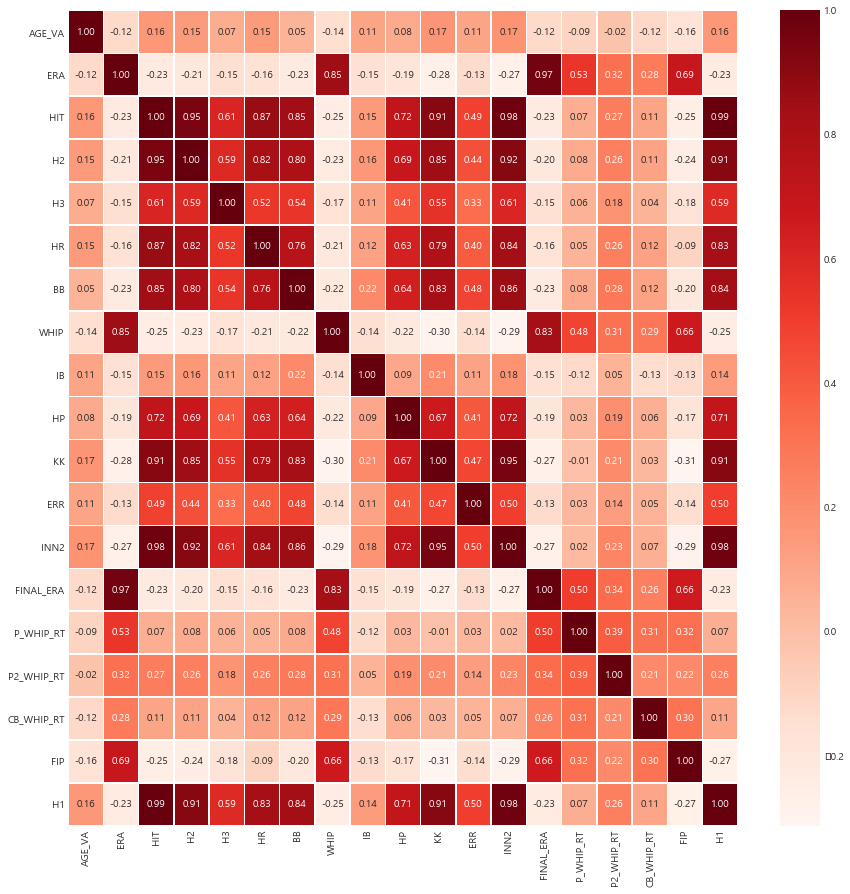

In [234]:
correlation_y=train.drop(['PCODE', 'T_ID', 'NAME', 'YEAR', 'INN'], axis=1)

plt.figure(figsize=(15,15))
sns.heatmap(data = correlation_y.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Reds')

해석
1) ERA와 FINAL ERA간의 상관계수 = 0.97로 매우매우 높음 - 2020 120경기 ERA로 최종 ERA 예측 가능
(이는 144 경기 ERA에서 120경기 ERA가 차지하는 비중이 크기 때문인 것 같음. 비교지표로 사용가능할 듯)
2) ERA와 상관계수가 높은 값 : WHIP, FIP, P_WHIP_RT (0.5를 넘김)
3) FINAL ERA와 상관계수가 높은 값 : WHIP, P_WHIP_RT, FIP

피안타(HIT)와 상관관계가 높은 값
1루타(H1), 2루타(H2), 3루타(H3), 홈런(HR), 볼넷(BB), 데드볼(HP), 삼진(KK), 이닝수(INN2) + 실책(ERR)

이 변수들은 서로서로 상관관계가 높음, multicollinearity 발생 가능성 있음


WHIP : 이닝당 안타+볼넷 허용률, (피안타+볼넷)/이닝
FIP : (13*피홈런+3(볼넷+데드볼-고의4구)-2*삼진)/이닝수 +C (c값은 연도마다 조금 다름)

FIP에 사용된 변수 : 피홈런(HR), 볼넷(BB), 데드볼(HP) 고의4구(IB), 삼진(KK), 이닝수(INN2)

WHIP에 사용된 변수 : 피안타(HIT), 볼넷(BB), 이닝수(INN2)

FIP와 WHIP에 사용되지 않은 변수 : 1루타, 2루타, 3루타, 실책
(실책 변수가 들어가지 않았는데 상관관계가 존재하기 때문에 이를 고려해보면 괜찮을 것 같음)

ERA와 상관계수가 높은 WHIP, FIP, P_WHIP_RT
WHIP는 FIP와 상관계수가 높음, P_WHIP_RT와 상관관계를 가짐



Text(0, 0.5, 'FINAL_ERA')

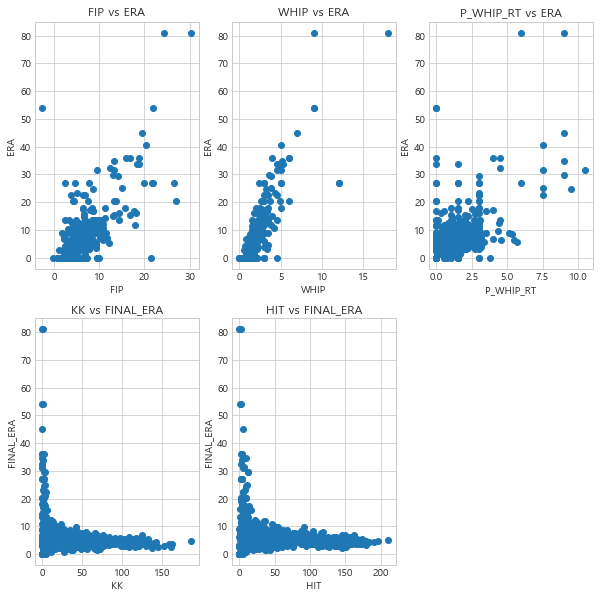

In [235]:
plt.figure(figsize=[10, 10])

plt.subplot(2, 3, 1)
plt.scatter(train['FIP'], train['ERA'])
plt.title('FIP vs ERA')
plt.xlabel('FIP')
plt.ylabel('ERA')

plt.subplot(2, 3, 2)
plt.scatter(train['WHIP'], train['ERA'])
plt.title('WHIP vs ERA')
plt.xlabel('WHIP')
plt.ylabel('ERA')

plt.subplot(2, 3, 3)
plt.scatter(train['P_WHIP_RT'], train['ERA'])
plt.title('P_WHIP_RT vs ERA')
plt.xlabel('P_WHIP_RT')
plt.ylabel('ERA')


plt.subplot(2, 3, 4)
plt.scatter(train['KK'], train['FINAL_ERA'])
plt.title('KK vs FINAL_ERA')
plt.xlabel('KK')
plt.ylabel('FINAL_ERA')


plt.subplot(2, 3, 5)
plt.scatter(train['HIT'], train['FINAL_ERA'])
plt.title('HIT vs FINAL_ERA')
plt.xlabel('HIT')
plt.ylabel('FINAL_ERA')


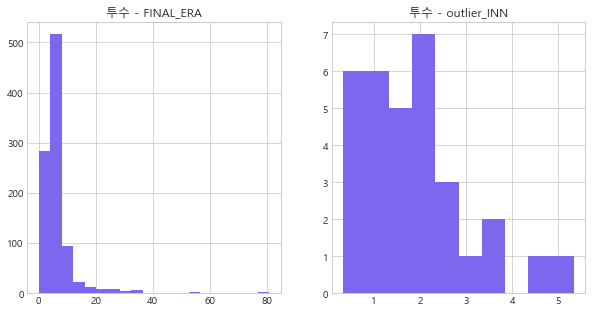

In [236]:
plt.figure(figsize=[10, 5])

plt.subplot(1, 2, 1)
plt.hist(train['FINAL_ERA'], bins=20 ,color='mediumslateblue')
plt.title('투수 - FINAL_ERA')

plt.subplot(1, 2, 2)
plt.hist(train[train['FINAL_ERA']>20]['INN'], color='mediumslateblue')
plt.title('투수 - outlier_INN')
plt.show()

ERA를 보면 81로 매우 높은 값을 가지는 선수가 존재하는데, 이는 참여한 이닝수가 1을 넘지 않는 선수이므로, 이를 제외시켜서 다시 생각

In [237]:
train_remove=train[train['INN']>=10]

print(train_remove.info())
print(train_remove.describe())

#10이닝 이상 뛴 선수 수 : 705명으로 전체 데이터 960에서 255명이 10이닝 이하로 출전함
#FINAL_ERA 또한 6.9에서 4.9로 줄어든 것을 볼 수 있음

<class 'pandas.core.frame.DataFrame'>
Int64Index: 705 entries, 0 to 954
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   PCODE       705 non-null    int64  
 1   NAME        705 non-null    object 
 2   T_ID        705 non-null    object 
 3   AGE_VA      705 non-null    int64  
 4   ERA         705 non-null    float64
 5   HIT         705 non-null    int64  
 6   H2          705 non-null    int64  
 7   H3          705 non-null    int64  
 8   HR          705 non-null    int64  
 9   BB          705 non-null    int64  
 10  WHIP        705 non-null    float64
 11  IB          705 non-null    int64  
 12  HP          705 non-null    int64  
 13  KK          705 non-null    int64  
 14  ERR         705 non-null    int64  
 15  INN2        705 non-null    int64  
 16  INN         705 non-null    float64
 17  FINAL_ERA   705 non-null    float64
 18  P_WHIP_RT   705 non-null    float64
 19  P2_WHIP_RT  705 non-null    f

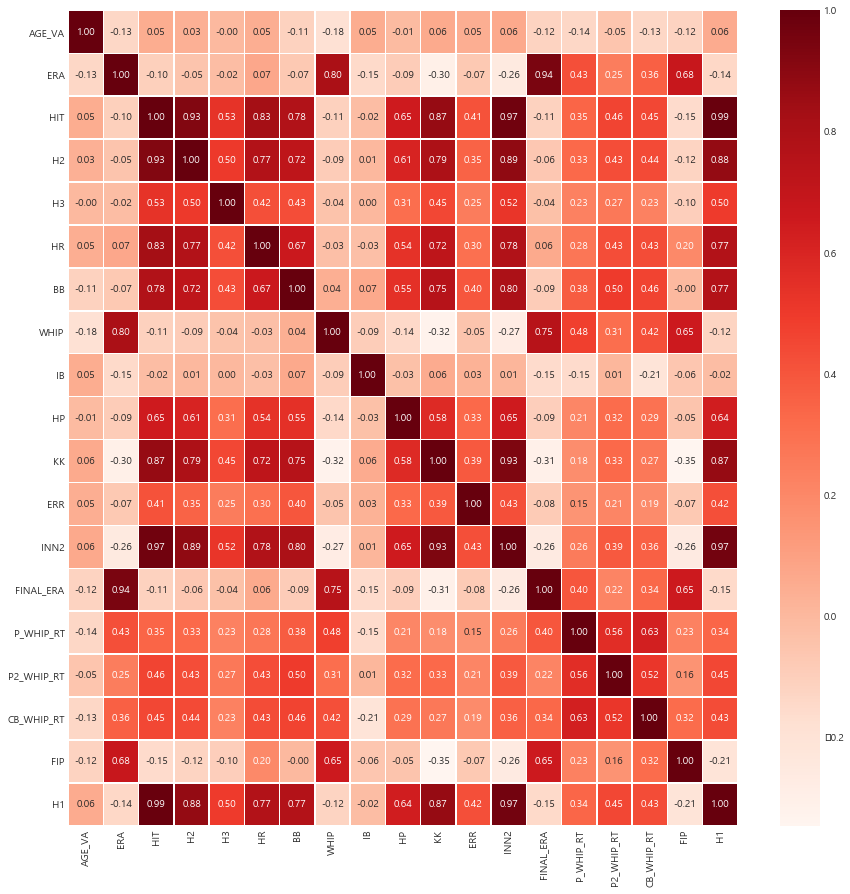

In [238]:
correlation_y=train_remove.drop(['PCODE', 'T_ID', 'NAME', 'YEAR', 'INN'], axis=1)

plt.figure(figsize=(15,15))
sns.heatmap(data = correlation_y.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Reds')

해석

1. 10이닝 빼도, ERA와 FINAL_ERA는 높은 상관관계를 가짐
2. FINAL_ERA와 높은 상관관계를 가지는 값 : WHIP, FIP + P_WHIP_RT
3. ERA와 높은 상관관계를 가지는 값 : FIP, P_WHIP_RT, WHIP

HIT과 H1, H2, H3, HR, BB, HP, KK, INN는 높은 상관관계를 가지고 있음
이들을 모두 변수로 채용할 경우 multicollinearity 발생 가능성 있음

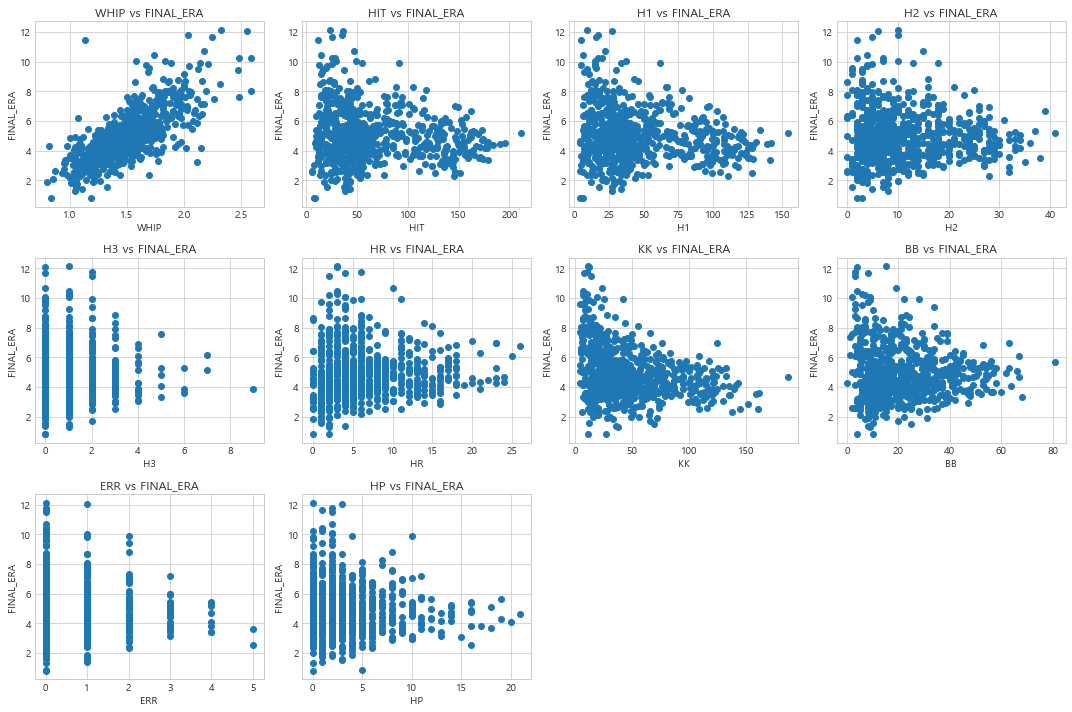

In [239]:
# scatter plot 비교

plt.figure(figsize=[15, 10])

plt.subplot(3, 4, 1)
plt.scatter(train_remove['WHIP'], train_remove['FINAL_ERA'])
plt.title('WHIP vs FINAL_ERA')
plt.xlabel('WHIP')
plt.ylabel('FINAL_ERA')

#WHIP와 FINAL_ERA는 강한 양의 상관관계

plt.subplot(3, 4, 2)
plt.scatter(train_remove['HIT'], train_remove['FINAL_ERA'])
plt.title('HIT vs FINAL_ERA')
plt.xlabel('HIT')
plt.ylabel('FINAL_ERA')

plt.subplot(3, 4, 3)
plt.scatter(train_remove['H1'], train_remove['FINAL_ERA'])
plt.title('H1 vs FINAL_ERA')
plt.xlabel('H1')
plt.ylabel('FINAL_ERA')

plt.subplot(3, 4, 4)
plt.scatter(train_remove['H2'], train_remove['FINAL_ERA'])
plt.title('H2 vs FINAL_ERA')
plt.xlabel('H2')
plt.ylabel('FINAL_ERA')

plt.subplot(3, 4, 5)
plt.scatter(train_remove['H3'], train_remove['FINAL_ERA'])
plt.title('H3 vs FINAL_ERA')
plt.xlabel('H3')
plt.ylabel('FINAL_ERA')

plt.subplot(3, 4, 6)
plt.scatter(train_remove['HR'], train_remove['FINAL_ERA'])
plt.title('HR vs FINAL_ERA')
plt.xlabel('HR')
plt.ylabel('FINAL_ERA')

plt.subplot(3, 4, 7)
plt.scatter(train_remove['KK'], train_remove['FINAL_ERA'])
plt.title('KK vs FINAL_ERA')
plt.xlabel('KK')
plt.ylabel('FINAL_ERA')

plt.subplot(3, 4, 8)
plt.scatter(train_remove['BB'], train_remove['FINAL_ERA'])
plt.title('BB vs FINAL_ERA')
plt.xlabel('BB')
plt.ylabel('FINAL_ERA')


# HIT, H1, H2, H3, HR, KK, BB와 ERA를 scatter plot으로 나타내면 대부분 비슷한 모양의 plot이 그려짐 - 이에 대한 해석 필요
# 대부분의 데이터값들이 0에 과 10 사이에 몰려 있는데, 이닝 수가 많으면 상대적으로 피안타, 삼진, 사구의 개수가 많아지기 때문

plt.subplot(3, 4, 9)
plt.scatter(train_remove['ERR'], train_remove['FINAL_ERA'])
plt.title('ERR vs FINAL_ERA')
plt.xlabel('ERR')
plt.ylabel('FINAL_ERA')

plt.subplot(3, 4, 10)
plt.scatter(train_remove['HP'], train_remove['FINAL_ERA'])
plt.title('HP vs FINAL_ERA')
plt.xlabel('HP')
plt.ylabel('FINAL_ERA')

plt.tight_layout()

plt.show()


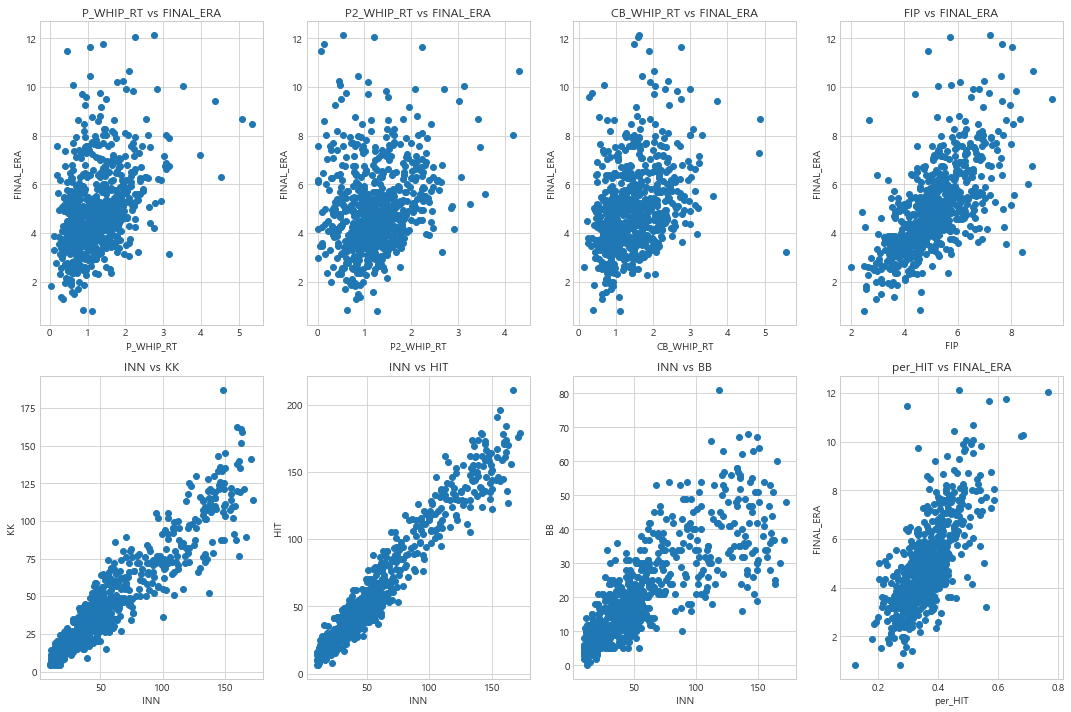

In [240]:
plt.figure(figsize=[15, 10])

plt.subplot(2, 4, 1)
plt.scatter(train_remove['P_WHIP_RT'], train_remove['FINAL_ERA'])
plt.title('P_WHIP_RT vs FINAL_ERA')
plt.xlabel('P_WHIP_RT')
plt.ylabel('FINAL_ERA')

plt.subplot(2, 4, 2)
plt.scatter(train_remove['P2_WHIP_RT'], train_remove['FINAL_ERA'])
plt.title('P2_WHIP_RT vs FINAL_ERA')
plt.xlabel('P2_WHIP_RT')
plt.ylabel('FINAL_ERA')

plt.subplot(2, 4, 3)
plt.scatter(train_remove['CB_WHIP_RT'], train_remove['FINAL_ERA'])
plt.title('CB_WHIP_RT vs FINAL_ERA')
plt.xlabel('CB_WHIP_RT')
plt.ylabel('FINAL_ERA')

plt.subplot(2, 4, 4)
plt.scatter(train_remove['FIP'], train_remove['FINAL_ERA'])
plt.title('FIP vs FINAL_ERA')
plt.xlabel('FIP')
plt.ylabel('FINAL_ERA')

plt.subplot(2, 4, 5)
plt.scatter(train_remove['INN'], train_remove['KK'])
plt.title('INN vs KK')
plt.xlabel('INN')
plt.ylabel('KK')

plt.subplot(2, 4, 6)
plt.scatter(train_remove['INN'], train_remove['HIT'])
plt.title('INN vs HIT')
plt.xlabel('INN')
plt.ylabel('HIT')

#피안타, 볼넷, 삼진들의 값들이 0에 가까운 값에 몰려 있음, 또한 이닝수가 많을수록 위의 값들이 커질 수 있음

plt.subplot(2, 4, 7)
plt.scatter(train_remove['INN'], train_remove['BB'])
plt.title('INN vs BB')
plt.xlabel('INN')
plt.ylabel('BB')


train_remove['per_KK']=train_remove['HIT']/train_remove['INN2']
train_remove['per_HIT']=train_remove['HIT']/train_remove['INN2']
plt.subplot(2, 4, 8)
plt.scatter(train_remove['per_HIT'], train_remove['FINAL_ERA'])
plt.title('per_HIT vs FINAL_ERA')
plt.xlabel('per_HIT')
plt.ylabel('FINAL_ERA')
plt.tight_layout()
plt.show()

#보면 알 수 있듯이, 이닝을 나누어준 지표와 ERA와 비교했을 때 강한 양의 상관관계를 가지는 것을 알 수 있음.

#위의 상관계수를 확인해도 그렇고, 직접 scatter plot을 그려봐도 알 수 있듯이, HIT, KK, BB, H1, H2, H3, HR과 INN 사이에는 
#양의 상관관계가 확실히 존재함.

#위 지표를 이닝으로 나눈 새로운 지표 사용 필요성!


In [241]:
#scaling 해주기 - HIT, H1, H2, H3, HR, KK, BB, HB, ERR, IB값을 INN2으로 나눈 새로운 dataframe 만들기

train_scaling=train_remove[['HIT', 'H1', 'H2', 'H3', 'HR', 'KK', 'BB', 'HP', 'ERR', 'IB', 'FINAL_ERA', 'ERA']]
train_scaling['per_HIT']=train_scaling['HIT']/train_remove['INN2']
train_scaling['per_H1']=train_scaling['H1']/train_remove['INN2']
train_scaling['per_H2']=train_scaling['H2']/train_remove['INN2']
train_scaling['per_H3']=train_scaling['H3']/train_remove['INN2']
train_scaling['per_HR']=train_scaling['HR']/train_remove['INN2']
train_scaling['per_KK']=train_scaling['KK']/train_remove['INN2']
train_scaling['per_BB']=train_scaling['BB']/train_remove['INN2']
train_scaling['per_HP']=train_scaling['HP']/train_remove['INN2']
train_scaling['per_ERR']=train_scaling['ERR']/train_remove['INN2']
train_scaling['per_IB']=train_scaling['IB']/train_remove['INN2']

train_scaling=train_scaling.drop(['HIT', 'H1', 'H2', 'H3', 'HR', 'KK', 'BB', 'HP', 'ERR', 'IB'], axis=1)

In [242]:
train_scaling

,FINAL_ERA,ERA,per_HIT,per_H1,per_H2,per_H3,per_HR,per_KK,per_BB,per_HP,per_ERR,per_IB
0,4.829268,4.778761,0.353982,0.247788,0.061947,0.000000,0.044248,0.238938,0.150442,0.026549,0.000000,0.008850
1,3.311321,3.203390,0.350282,0.276836,0.050847,0.005650,0.016949,0.384181,0.158192,0.022599,0.000000,0.022599
2,7.147059,8.345455,0.545455,0.472727,0.054545,0.000000,0.018182,0.127273,0.181818,0.000000,0.036364,0.018182
3,5.155779,5.065868,0.421158,0.307385,0.081836,0.013972,0.017964,0.177645,0.059880,0.013972,0.000000,0.003992
5,4.169118,3.600000,0.216667,0.133333,0.058333,0.008333,0.016667,0.225000,0.175000,0.033333,0.000000,0.025000
...,...,...,...,...,...,...,...,...,...,...,...,...
946,4.628571,4.628571,0.285714,0.114286,0.085714,0.028571,0.057143,0.257143,0.285714,0.000000,0.000000,0.000000
947,2.750000,2.800000,0.274074,0.229630,0.022222,0.000000,0.022222,0.288889,0.088889,0.014815,0.000000,0.007407
949,4.178571,4.068493,0.287671,0.219178,0.041096,0.000000,0.027397,0.205479,0.082192,0.054795,0.000000,0.000000
951,7.061538,7.363636,0.363636,0.181818,0.151515,0.000000,0.030303,0.181818,0.181818,0.060606,0.000000,0.000000


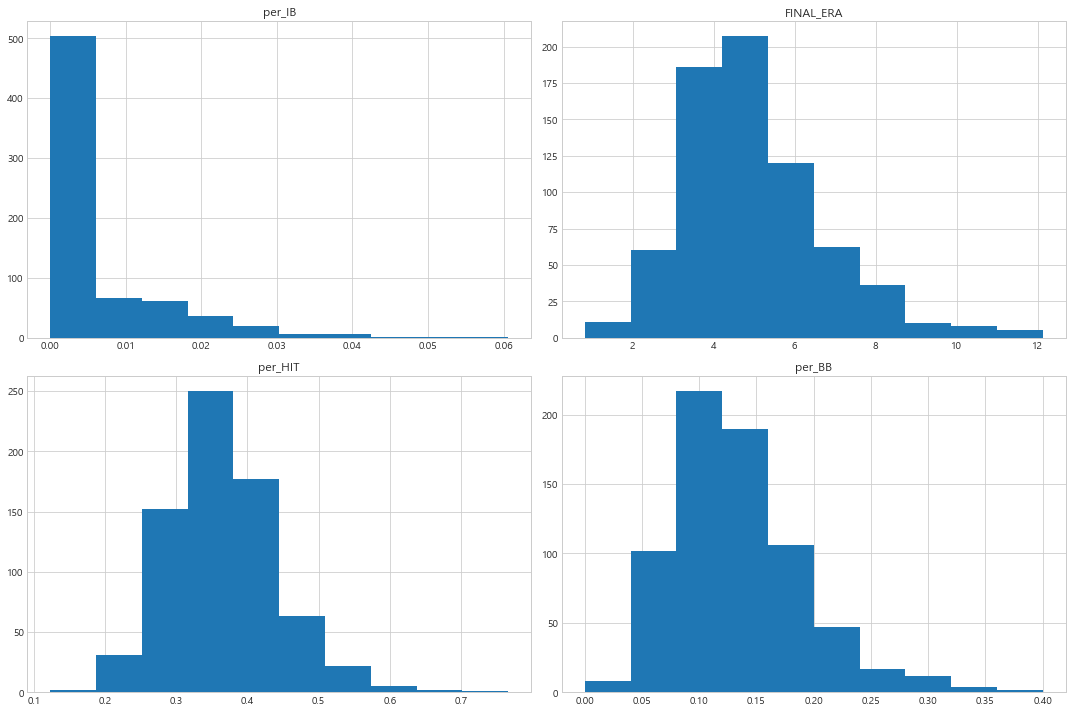

In [243]:
plt.figure(figsize=[15, 10])

plt.subplot(2, 2, 1)
plt.hist(train_scaling['per_IB'])
plt.title('per_IB')

plt.subplot(2, 2, 2)
plt.hist(train_scaling['FINAL_ERA'])
plt.title('FINAL_ERA')

plt.subplot(2, 2, 3)
plt.hist(train_scaling['per_HIT'])
plt.title('per_HIT')

plt.subplot(2, 2, 4)
plt.hist(train_scaling['per_BB'])
plt.title('per_BB')


plt.tight_layout()
plt.show()

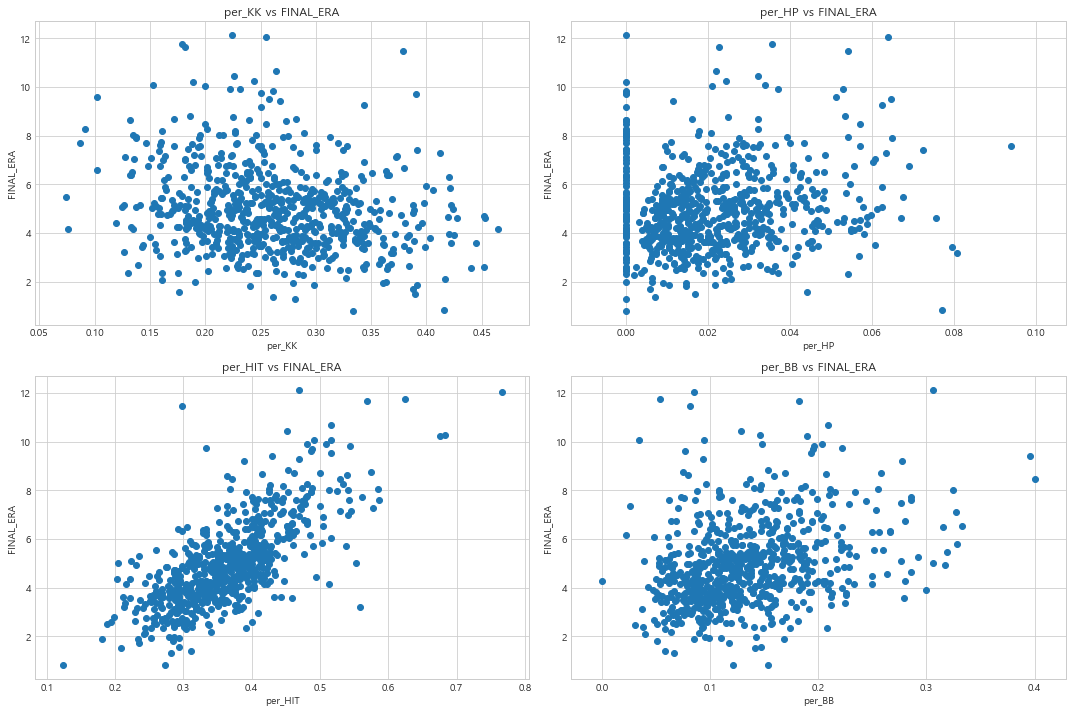

In [244]:
plt.figure(figsize=[15, 10])

plt.subplot(2, 2, 1)
plt.scatter(train_scaling['per_KK'], train_remove['FINAL_ERA'])
plt.title('per_KK vs FINAL_ERA')
plt.xlabel('per_KK')
plt.ylabel('FINAL_ERA')

plt.subplot(2, 2, 2)
plt.scatter(train_scaling['per_HP'], train_remove['FINAL_ERA'])
plt.title('per_HP vs FINAL_ERA')
plt.xlabel('per_HP')
plt.ylabel('FINAL_ERA')

plt.subplot(2, 2, 3)
plt.scatter(train_scaling['per_HIT'], train_remove['FINAL_ERA'])
plt.title('per_HIT vs FINAL_ERA')
plt.xlabel('per_HIT')
plt.ylabel('FINAL_ERA')

plt.subplot(2, 2, 4)
plt.scatter(train_scaling['per_BB'], train_remove['FINAL_ERA'])
plt.title('per_BB vs FINAL_ERA')
plt.xlabel('per_BB')
plt.ylabel('FINAL_ERA')

plt.tight_layout()
plt.show()

#final ERA와 상관관계가 있는 변수들이 생김

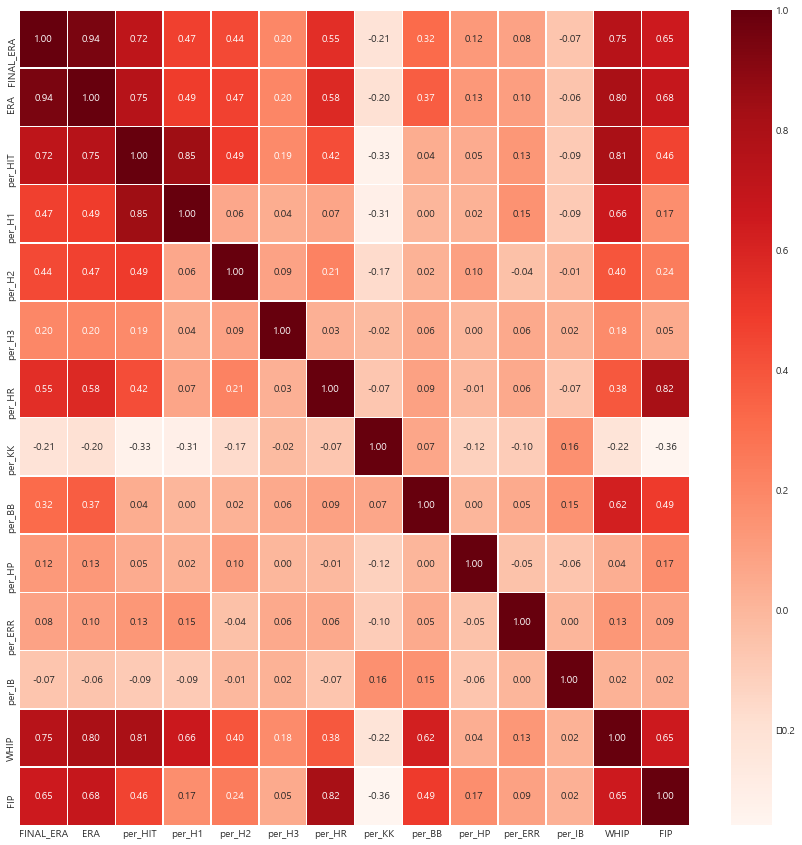

In [245]:
train_scaling['WHIP']=train_remove['WHIP']
train_scaling['FIP']=train_remove['FIP']

plt.figure(figsize=(15,15))
sns.heatmap(data = train_scaling.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Reds')

FIP와 WHIP 계산 식에서 HIT, H1, H2, BB, KK와 같은 지표의 일차식을 INN2로 나누었기 때문에, 상관관계가 높게 나오는 것을 알 수 있음


In [246]:
# best subset selection

def bestsubset(x, y):
    BIC=[]
    feature=[]
    MAX_CON=[]
    MIN_CON=[]
    
    for i in range(x.shape[0]) :
        feature_list=list(combinations(x.columns, i+1))
        
        for j in range(len(feature_list)) :
            x_feature=x[list(feature_list[j])]
            sm.add_constant(x_feature)
            lm=sm.OLS(endog=y, exog=x_feature).fit()
            bic=lm.bic
            BIC.append(bic)
            max_con=np.max(lm.eigenvals)
            MAX_CON.append(max_con)
            min_con=np.min(lm.eigenvals)
            MIN_CON.append(min_con)

            
            
            if j%100 ==0 :
                print('performing...')
       
        feature=feature+feature_list
        
    
    result=pd.DataFrame({'feature' : feature, 'BIC' : BIC, 'MAX_CON' : MAX_CON, 'MIN_CON' : MIN_CON})
    
    return(result)


In [247]:
train_scaling['P_WHIP_RT']=train_remove['P_WHIP_RT']
train_scaling['P2_WHIP_RT']=train_remove['P2_WHIP_RT']
train_scaling['CB_WHIP_RT']=train_remove['CB_WHIP_RT']

train_x=train_scaling.drop('FINAL_ERA', axis=1)
train_y=train_scaling['FINAL_ERA']

In [143]:
bic_result=bestsubset(x=train_x, y=train_y)

performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
perfor

performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
performing...
perfor

In [144]:
bic_result=bic_result.sort_values('BIC')
bic_result.head(10)

,feature,BIC,MAX_CON,MIN_CON
999,"(ERA, per_HR, per_BB, FIP)",1252.315535,38436.702094,1.088207e-01
3555,"(ERA, per_HR, per_KK, per_BB, FIP)",1254.140081,38479.478822,1.069826e-01
3590,"(ERA, per_HR, per_BB, per_HP, FIP)",1256.764815,38437.036698,7.765210e-02
3596,"(ERA, per_HR, per_BB, per_ERR, FIP)",1257.858170,38436.710647,2.279838e-02
3399,"(ERA, per_H3, per_HR, per_BB, FIP)",1257.980480,38436.731941,4.737245e-02
9428,"(ERA, per_HR, per_KK, per_BB, per_HP, FIP)",1258.318739,38479.813456,7.725764e-02
3014,"(ERA, per_H1, per_HR, per_BB, FIP)",1258.329055,38481.197034,6.477335e-02
7609,"(ERA, per_HIT, per_HR, per_BB, WHIP, FIP)",1258.388929,40129.614004,3.928538e-30
2728,"(ERA, per_HIT, per_HR, per_BB, FIP)",1258.388929,38531.050785,6.970526e-02
2750,"(ERA, per_HIT, per_HR, WHIP, FIP)",1258.388929,40116.575315,7.242138e-02


In [248]:
lm_pitcher=smf.ols('FINAL_ERA ~ ERA + per_HR + per_BB +FIP', data=train_scaling).fit()
lm_pitcher.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              FINAL_ERA   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     1450.
Date:                Sat, 26 Sep 2020   Prob (F-statistic):               0.00
Time:                        16:34:25   Log-Likelihood:                -611.45
No. Observations:                 705   AIC:                             1233.
Df Residuals:                     700   BIC:                             1256.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2252      0.127      1.778      0.076      -0.023       0.474
ERA            0.8913      0.016     54.898      0.000       0.859       0.923
per_HR        -5.7982      2.249     -2.578      0.010     -10.214      -1.383
per_BB        -2.1686      0.562     -3.861      0.000      -3.271      -1.066
FIP            0.1623      0.049      3.313      0.001       0.066       0.259
==============================================================================
Omnibus:                      154.704   Durbin-Watson:                   1.808
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1509.419
Skew:                           0.677   Prob(JB):                         0.00
Kurtosis:                      10.039   Cond. No.                         780.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.5, 1.0, 'residual plot')

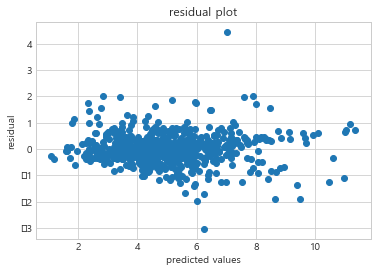

In [249]:
# residual plot check

ypred=lm_pitcher.fittedvalues
residual=lm_pitcher.resid


plt.scatter(ypred, residual)
plt.xlabel('predicted values')
plt.ylabel('residual')
plt.title('residual plot')

#looks like random, constant varaince 만족

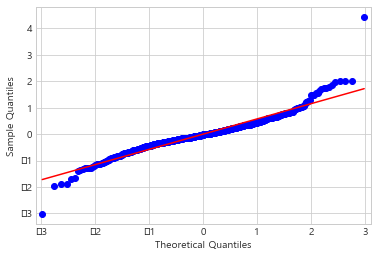

In [250]:
#normality


fig=sm.qqplot(residual, line='s')
plt.show()

#마지막 두 점을 제외하고 거의 직선위에 존재 - 만족한다고 볼 수 있음

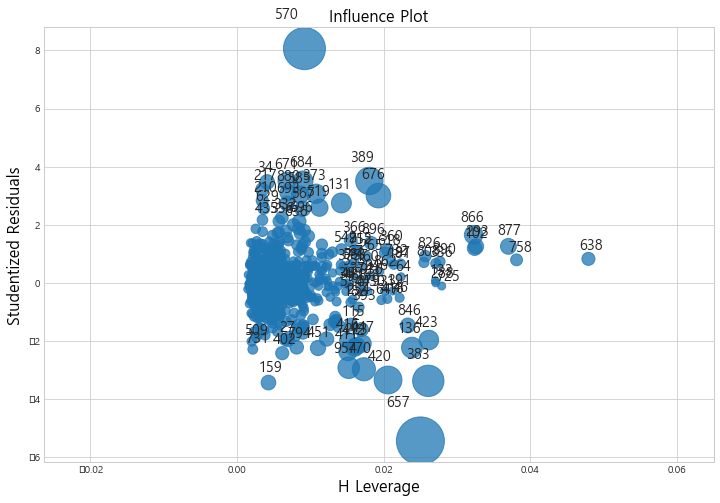

In [251]:
#checking cook's distance
fig, ax = plt.subplots(figsize=(12, 8))
fig = sm.graphics.influence_plot(lm_pitcher, ax=ax, criterion='cooks')

#570, 500, 657 data가 influential observation - (cook's distance에 벗어나지 않아서 만족은 하지만, 특이값으로 인식 가능)


In [252]:
np.mean(residual**2)

0.3317877154126657

# 최종 FINAL 변수 : ERA + per_HR + per_BB +FIP

# 2016 ~ 2018 data : train, 2019 : test로 예측해보기

In [253]:
train_remove=train[train['INN']>=10]

train1618 = train_remove[train_remove['YEAR']<=2018]
test19 = train_remove[train_remove['YEAR']==2019]

train1618['per_HR']=train1618['HR']/train1618['INN2']
train1618['per_BB']=train1618['BB']/train1618['INN2']
train1618['per_KK']=train1618['KK']/train1618['INN2']


test19['per_HR']=test19['HR']/test19['INN2']
test19['per_BB']=test19['BB']/test19['INN2']
test19['per_KK']=test19['KK']/test19['INN2']


train1618_x=train1618[['ERA', 'per_HR', 'per_BB', 'FIP']]

train1618_y=train1618['FINAL_ERA']

test19_x=test19[['ERA', 'per_HR', 'per_BB', 'FIP']]
test19_y=test19['FINAL_ERA']

In [254]:
lm_model=smf.ols('FINAL_ERA ~ ERA + per_HR + per_BB + FIP', data=train1618).fit()

lm_predy=lm_model.predict(test19_x)

In [255]:
np.mean((lm_predy-test19_y)**2)

0.25437213816449744

In [256]:
lm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              FINAL_ERA   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     882.2
Date:                Sat, 26 Sep 2020   Prob (F-statistic):          1.21e-231
Time:                        16:34:27   Log-Likelihood:                -485.37
No. Observations:                 531   AIC:                             980.7
Df Residuals:                     526   BIC:                             1002.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4712      0.163      2.892      0.004       0.151       0.791
ERA            0.8813      0.020     43.962      0.000       0.842       0.921
per_HR        -6.8880      2.678     -2.572      0.010     -12.149      -1.627
per_BB        -2.4346      0.708     -3.439      0.001      -3.825      -1.044
FIP            0.1473      0.061      2.412      0.016       0.027       0.267
==============================================================================
Omnibus:                      131.166   Durbin-Watson:                   1.784
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1109.846
Skew:                           0.820   Prob(JB):                    1.00e-241
Kurtosis:                       9.890   Cond. No.                         795.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# 예상 팀별 방어율 예측해보자

ERA + per_HR + per_BB +FIP

In [257]:
test19['INNPER']=test19['INN']/np.sum(test19['INN'])

TEAM_LIST = ['LG', 'SS', 'HH', 'LT', 'NC', 'HT', 'WO', 'SK', 'KT', 'OB']
for j in TEAM_LIST:
    s1 = "%s_%d = test19[(test19['T_ID']==j)&(test19['YEAR']==2019)]"%(j, 2019)
    exec(s1)
    
TEAM_LIST = ['LG', 'SS', 'HH', 'LT', 'NC', 'HT', 'WO', 'SK', 'KT', 'OB']
for j in TEAM_LIST:
    s1 = "%s_%d['INNPER']=%s_%d['INN']/%s_%d['INN'].sum()"%(j, 2019,j,2019,j,2019)
    exec(s1)
    
TEAM_LIST = ['LG', 'SS', 'HH', 'LT', 'NC', 'HT', 'WO', 'SK', 'KT', 'OB']
for j in TEAM_LIST:
    s1 = "%s_%d['PRED']=lm_model.predict(%s_%d[['ERA','per_HR','per_BB','FIP']])"%(j, 2019, j, 2019)
    exec(s1)
    
TEAM_LIST = ['LG', 'SS', 'HH', 'LT', 'NC', 'HT', 'WO', 'SK', 'KT', 'OB']

for j in TEAM_LIST:
    s2="%s_%d_pred=sum(%s_%d['PRED']*%s_%d['INNPER'])"%(j,2019,j,2019,j,2019)
    exec(s2)
    


pred_ERA=[LG_2019_pred, SS_2019_pred, HH_2019_pred, LT_2019_pred, NC_2019_pred, HT_2019_pred, WO_2019_pred, SK_2019_pred, KT_2019_pred, OB_2019_pred]

team_ERA=pd.DataFrame({'Team' : TEAM_LIST, 'pred_ERA' : pred_ERA})    

In [258]:
ERA=[3.86, 4.64, 4.80, 4.83, 4.01, 4.65, 3.61, 3.48, 4.29, 3.51]
team_ERA['true_ERA']=ERA
print(team_ERA)
print('-------------------------------------')
print('MSE : ', np.mean((team_ERA['pred_ERA']-team_ERA['true_ERA'])**2))
print('MAE : ', np.mean(np.abs(team_ERA['pred_ERA']-team_ERA['true_ERA'])))

  Team  pred_ERA  true_ERA
0   LG  3.988286      3.86
1   SS  4.605762      4.64
2   HH  4.855899      4.80
3   LT  4.726789      4.83
4   NC  3.947561      4.01
5   HT  4.695490      4.65
6   WO  3.942204      3.61
7   SK  3.437759      3.48
8   KT  4.442413      4.29
9   OB  3.612475      3.51
-------------------------------------
MSE :  0.018324955228613927
MAE :  0.10588950648800655


# 잔여경기 예측하기

In [259]:
train['ER_120']=train['ERA']*train['INN2']/27

team_120_ERA=(train[train['YEAR']==2019].groupby('T_ID').sum()['ER_120']*27)/(train[train['YEAR']==2019].groupby('T_ID').sum()['INN2'])

t=pd.DataFrame(team_120_ERA).reset_index().rename(columns={'T_ID' : 'Team', 0 : 'ERA_120'})
team_ERA=pd.merge(team_ERA, t, on='Team', how='left')

In [260]:
team_ERA

,Team,pred_ERA,true_ERA,ERA_120
0,LG,3.988286,3.86,3.855961
1,SS,4.605762,4.64,4.599875
2,HH,4.855899,4.80,5.023458
3,LT,4.726789,4.83,4.851874
4,NC,3.947561,4.01,4.003738
5,HT,4.695490,4.65,4.738185
6,WO,3.942204,3.61,3.830683
7,SK,3.437759,3.48,3.347327
8,KT,4.442413,4.29,4.394366
9,OB,3.612475,3.51,3.384495


In [261]:
team_ERA['pred_24_ERA']=(team_ERA['pred_ERA']-(120* team_ERA['ERA_120'])/144 )*144/24

In [262]:
team_ERA['True_24_ERA']=[3.024, 4.306220096, 2.925696594, 3.52173913, 3.062300319, 3.642495784, 1.980861244, 3.765451664,
                         3.531456954, 3.354294479]

In [263]:
print(team_ERA[['pred_24_ERA', 'True_24_ERA']])
print('-------------------------------------------------')
print('MSE :', np.mean((team_ERA['pred_24_ERA']-team_ERA['True_24_ERA'])**2))
print('MAE :', np.mean(np.abs(team_ERA['pred_24_ERA']-team_ERA['True_24_ERA'])))

   pred_24_ERA  True_24_ERA
0     4.649911     3.024000
1     4.635200     4.306220
2     4.018103     2.925697
3     4.101367     3.521739
4     3.666676     3.062300
5     4.482013     3.642496
6     4.499812     1.980861
7     3.889921     3.765452
8     4.682649     3.531457
9     4.752375     3.354294
-------------------------------------------------
MSE : 1.4991672717105726
MAE : 1.0263509873662344


# 잔여경기 MAE 차이 원인


1. 최종 ERA의 오차가 조금만 커져도 잔여경기 오차가 차이가 많이 남 (이는 최종 ERA에서 120경기 ERA이 사용되었기 때문)
2. 최종 ERA 값에서 120경기 ERA이 차지하는 비중이 큼
3. 모델을 만들 때 시간 지표(ex : 연도)를 반영하지 못함
4. 모델을 만들 때 팀 지표(팀의 특징 등등)를 반영하지 못함.